---
# Machine learning : `ozone_complet` (Test)
---

## Packages

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree

import joblib
import time

## Configuration machine

Pour connaître le nombre de coeurs de sa machine :

In [2]:
n_cores = joblib.cpu_count(only_physical_cores=True)
print(f'Nombre de coeurs (physiques): {n_cores}')

Nombre de coeurs (physiques): 12


---
## 1. Données
---

### 1.1. Importation

In [3]:
# En local :
directory = '/Users/vincentlefieux/Dropbox/Docs_ACADEMIQUE/Data/'

# Sur Google collab ou Onyxia (sur un répertoire temporaire) :
# directory = ''

# Sur Google collab (sur le drive) :
# from google.colab import drive
# drive.mount('/content/drive')
# directory = '/content/drive/MyDrive/Data/'

In [4]:
data = pd.read_csv(directory + 'ozone_complet.csv',
                   header    = 0,
                   index_col = 0,
                   sep       = ';',
                   decimal   = ',')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, 19950401 to 20020930
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   maxO3   1391 non-null   float64
 1   T6      1463 non-null   float64
 2   T9      1463 non-null   float64
 3   T12     1463 non-null   float64
 4   T15     1463 non-null   float64
 5   T18     1463 non-null   float64
 6   Ne6     1462 non-null   float64
 7   Ne9     1462 non-null   float64
 8   Ne12    1462 non-null   float64
 9   Ne15    1462 non-null   float64
 10  Ne18    1459 non-null   float64
 11  Vdir6   1463 non-null   float64
 12  Vvit6   1463 non-null   float64
 13  Vdir9   1463 non-null   float64
 14  Vvit9   1463 non-null   float64
 15  Vdir12  1463 non-null   float64
 16  Vvit12  1463 non-null   float64
 17  Vdir15  1463 non-null   float64
 18  Vvit15  1463 non-null   float64
 19  Vdir18  1463 non-null   float64
 20  Vvit18  1463 non-null   float64
 21  Vx      1463 non-null   float64

In [6]:
data.head()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
date,,,,,,,,,,,,,,,,,,,,,
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8


### 1.2. Gestion des données manquantes

In [7]:
missing_percentage = data.isna().mean() * 100

print('MISSING VALUES :')
if missing_percentage[missing_percentage != 0].empty:
    print('No')
else:
    print(missing_percentage[missing_percentage != 0].sort_values(ascending=False))

MISSING VALUES :
maxO3     4.986339
maxO3v    4.986339
Ne18      0.341530
Ne6       0.136612
Ne9       0.136612
Ne12      0.136612
Ne15      0.136612
T9        0.068306
Vdir12    0.068306
Vx        0.068306
Vvit18    0.068306
Vdir18    0.068306
Vvit15    0.068306
Vdir15    0.068306
Vvit12    0.068306
Vvit6     0.068306
Vvit9     0.068306
Vdir9     0.068306
T12       0.068306
T6        0.068306
T18       0.068306
T15       0.068306
Vdir6     0.068306
dtype: float64


Vu que les données manquantes concernent essentiellement le pic d'ozone qu'on cherche à prédire, on retire les données manquantes ici :

In [8]:
data.dropna(inplace=True)

### 1.3. Gestion des variables

In [9]:
target = 'maxO3'
features = list(data.columns.difference([target]))

X = data[features]
y = data[target]

### 1.4. Création d'un échantillon test

In [10]:
test_portion = 1/5

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=test_portion)

print('Dimensions X_train_valid :', X_train_valid.shape)
print('Dimensions X_test        :', X_test.shape)
print('Dimensions y_train_valid :', y_train_valid.shape)
print('Dimensions y_test        :', y_test.shape)

Dimensions X_train_valid : (1092, 22)
Dimensions X_test        : (274, 22)
Dimensions y_train_valid : (1092,)
Dimensions y_test        : (274,)


---
## 2. Modélisation
---

In [11]:
criteria = 'neg_mean_squared_error' # Pour le choix du critère CV (-MSE)
n_folds  = 10                       # Pour le nombre de blocs CV (10)
n_core   = -1                       # Pour l'utilisation de tous les coeurs disponibles
verbose  = 1                        # Pour le caractère "verbeux"

### 2.1. CART

A titre purement illustratif, avec un "petit" arbre (profondeur maximale de 2) :

In [12]:
cart_model = DecisionTreeRegressor(max_depth=2)
cart = cart_model.fit(X_train_valid, y_train_valid)

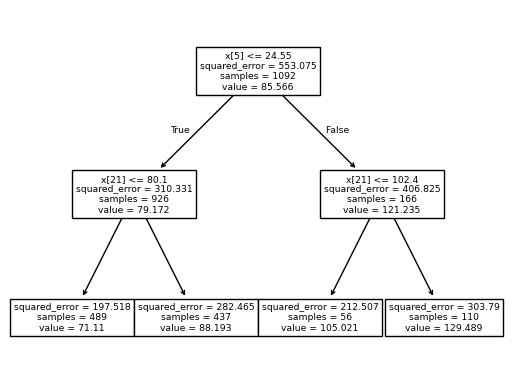

In [13]:
plot_tree(cart)
plt.show()

In [14]:
y_test_pred_cart = cart.predict(X_test)

In [15]:
mse_cart  = mean_squared_error(y_test, y_test_pred_cart)
mae_cart  = mean_absolute_error(y_test, y_test_pred_cart)
mape_cart = mean_absolute_percentage_error(y_test, y_test_pred_cart) * 100

print(f'MSE CART  : {mse_cart:.2f}')
print(f'MAE CART  : {mae_cart:.2f}')
print(f'MAPE CART : {mape_cart:.2f}')

MSE CART  : 222.92
MAE CART  : 11.58
MAPE CART : 15.00


Avec un "grand" arbre :

In [16]:
start_time = time.time()

In [17]:
cart_model = DecisionTreeRegressor()
cart = cart_model.fit(X_train_valid, y_train_valid)

In [18]:
y_test_pred_cart = cart.predict(X_test)

In [19]:
end_time = time.time()
execution_time_cart = end_time - start_time
print(f"Temps d'exécution CART : {execution_time_cart:.2f} secondes")

Temps d'exécution CART : 0.03 secondes


In [20]:
mse_cart  = mean_squared_error(y_test, y_test_pred_cart)
mae_cart  = mean_absolute_error(y_test, y_test_pred_cart)
mape_cart = mean_absolute_percentage_error(y_test, y_test_pred_cart) * 100

print(f'MSE CART  : {mse_cart:.2f}')
print(f'MAE CART  : {mae_cart:.2f}')
print(f'MAPE CART : {mape_cart:.2f}')

MSE CART  : 315.30
MAE CART  : 14.28
MAPE CART : 18.23


### 2.2. Random forest

In [21]:
start_time = time.time()

In [22]:
rf_model = RandomForestRegressor()

params_rf = {
    'n_estimators': [200, 300, 400, 500]
}

rf = GridSearchCV(estimator  = rf_model,
                  param_grid = params_rf,
                  scoring    = criteria,
                  cv         = n_folds,
                  n_jobs     = n_core,
                  verbose    = verbose)

rf.fit(X_train_valid, y_train_valid)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [200, 300, 400, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
y_test_pred_rf = rf.predict(X_test)

In [24]:
end_time = time.time()
execution_time_rf = end_time - start_time
print(f"Temps d'exécution Random forest : {execution_time_rf:.2f} secondes")

Temps d'exécution Random forest : 15.54 secondes


In [25]:
print('Hyperparamètre optimal Random forest :', rf.best_params_)

Hyperparamètre optimal Random forest : {'n_estimators': 500}


In [26]:
mse_rf  = mean_squared_error(y_test, y_test_pred_rf)
mae_rf  = mean_absolute_error(y_test, y_test_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100

print(f'MSE Random forest  : {mse_rf:.2f}')
print(f'MAE Random forest  : {mae_rf:.2f}')
print(f'MAPE Random forest : {mape_rf:.2f}')

MSE Random forest  : 136.91
MAE Random forest  : 9.06
MAPE Random forest : 11.83


On peut visualiser les résultats pour potentiellement réduire le nombre d'arbres choisi par validation croisée (si les performances sont proches) :

In [27]:
rf_out = pd.DataFrame(rf.cv_results_)
print(rf_out[['param_n_estimators', 'mean_test_score', 'std_test_score']])

   param_n_estimators  mean_test_score  std_test_score
0                 200      -160.330796       15.286406
1                 300      -159.648855       15.291895
2                 400      -159.257791       15.827304
3                 500      -159.238070       15.311516


On peut visualiser l'importance des variables :

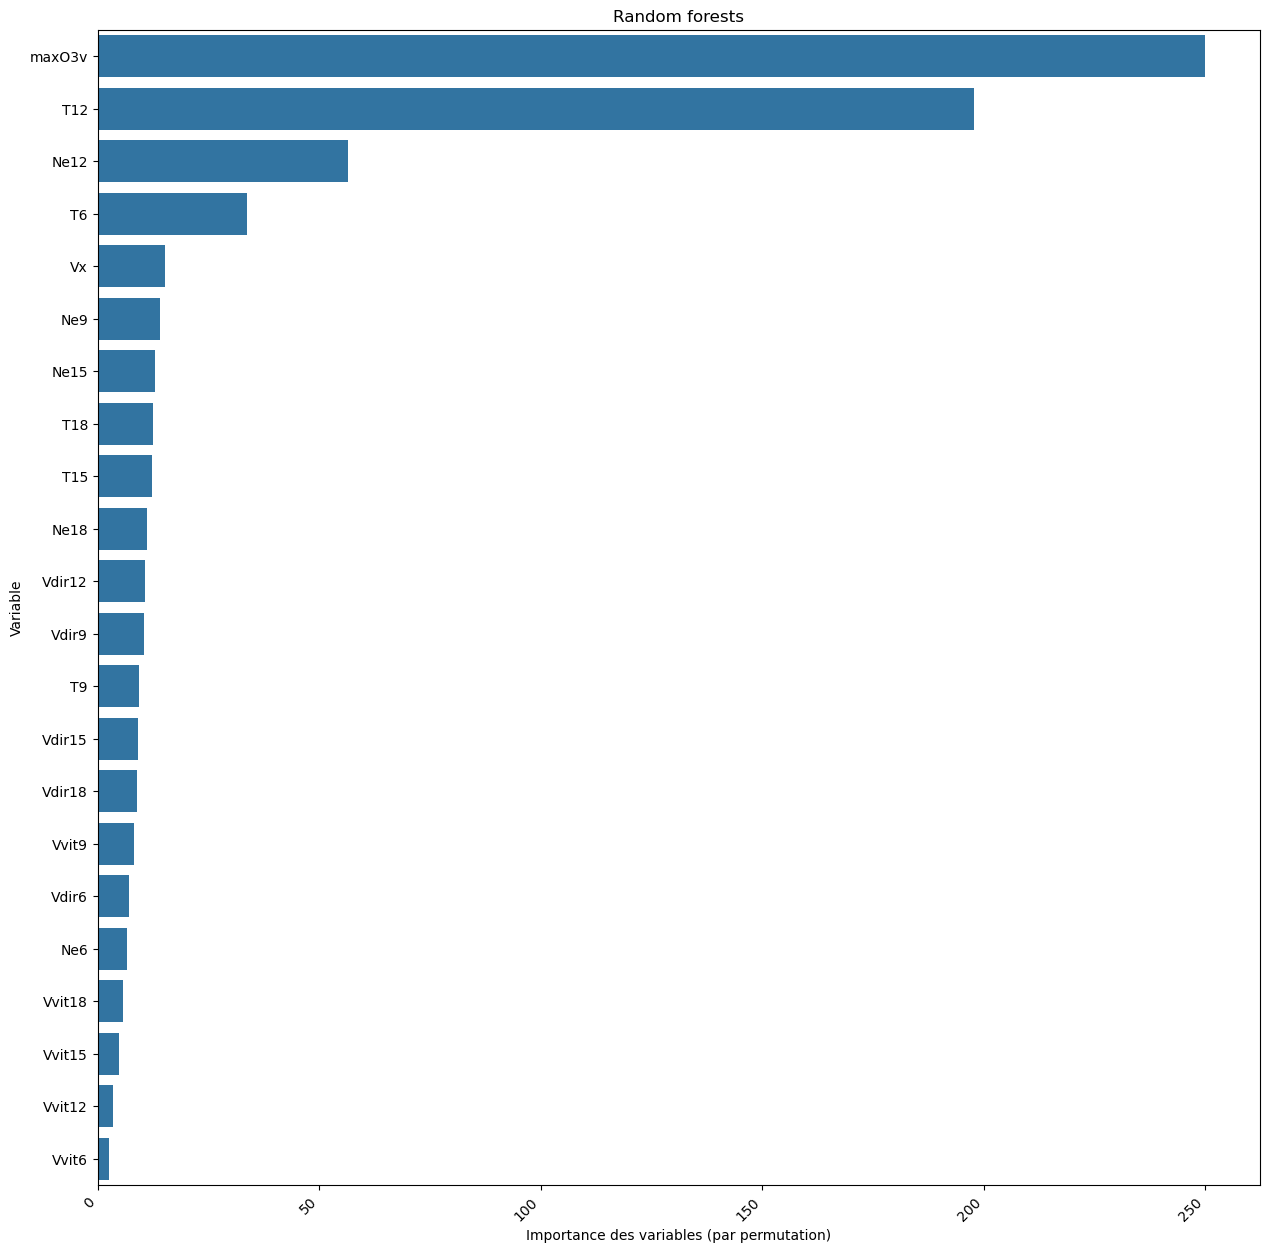

In [28]:
perm_importance_rf = permutation_importance(rf.best_estimator_, X_train_valid, y_train_valid, scoring=criteria, n_repeats=10, n_jobs=n_core)

perm_importance_df = pd.DataFrame({
    'Variable': X_train_valid.columns,
    'Importance': perm_importance_rf.importances_mean
    }).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Variable', data=perm_importance_df)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Importance des variables (par permutation)')
plt.ylabel('Variable')
plt.title('Random forests')
plt.show()

### 2.3. Gradient boosting

In [29]:
start_time = time.time()

In [30]:
gb_model = HistGradientBoostingRegressor(early_stopping=True, tol=1e-4)

params_gb = {
    'max_iter': [2000],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'loss': ['squared_error', 'absolute_error']
}

gb = GridSearchCV(estimator  = gb_model,
                  param_grid = params_gb,
                  scoring    = criteria,
                  cv         = n_folds,
                  n_jobs     = n_core,
                  verbose    = verbose)

gb.fit(X_train_valid, y_train_valid)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10,
             estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                     tol=0.0001),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_iter': [2000]},
             scoring='neg_mean_squared_error', verbose=1)

In [31]:
y_test_pred_gb = gb.predict(X_test)

In [32]:
end_time = time.time()
execution_time_gb = end_time - start_time
print(f"Temps d'exécution Gradient boosting : {execution_time_gb:.2f} secondes")

Temps d'exécution Gradient boosting : 1.21 secondes


In [33]:
print('Hyperparamètres optimaux Gradient boosting :', gb.best_params_)
print("Nombre d'itérations réel Gradient boosting :", gb.best_estimator_.n_iter_)

Hyperparamètres optimaux Gradient boosting : {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_iter': 2000}
Nombre d'itérations réel Gradient boosting : 39


In [34]:
mse_gb  = mean_squared_error(y_test, y_test_pred_gb)
mae_gb  = mean_absolute_error(y_test, y_test_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_test_pred_gb) * 100

print(f'MSE Gradient boosting  : {mse_gb:.2f}')
print(f'MAE Gradient boosting  : {mae_gb:.2f}')
print(f'MAPE Gradient boosting : {mape_gb:.2f}')

MSE Gradient boosting  : 139.31
MAE Gradient boosting  : 9.05
MAPE Gradient boosting : 11.95


### 2.4. SVM

In [35]:
start_time = time.time()

In [36]:
svm_model = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('svm', SVR())
])

params_svm = {
    'svm__gamma': [0.001, 0.01, 0.1, 1],
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__kernel': ['linear', 'poly', 'rbf']
}

svm = GridSearchCV(estimator  = svm_model,
                   param_grid = params_svm,
                   scoring    = criteria,
                   cv         = n_folds,
                   n_jobs     = n_core,
                   verbose    = verbose)

svm.fit(X_train_valid, y_train_valid)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100, 1000],
                         'svm__gamma': [0.001, 0.01, 0.1, 1],
                         'svm__kernel': ['linear', 'poly', 'rbf']},
             scoring='neg_mean_squared_error', verbose=1)

In [37]:
y_test_pred_svm = svm.predict(X_test)

In [38]:
end_time = time.time()
execution_time_svm = end_time - start_time
print(f"Temps d'exécution SVM : {execution_time_svm:.2f} secondes")

Temps d'exécution SVM : 63.62 secondes


In [39]:
print('Hyperparamètres optimaux SVM :', svm.best_params_)

Hyperparamètres optimaux SVM : {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


In [40]:
mse_svm  = mean_squared_error(y_test, y_test_pred_svm)
mae_svm  = mean_absolute_error(y_test, y_test_pred_svm)
mape_svm = mean_absolute_percentage_error(y_test, y_test_pred_svm) * 100

print(f'MSE SVM  : {mse_svm:.2f}')
print(f'MAE SVM  : {mae_svm:.2f}')
print(f'MAPE SVM : {mape_svm:.2f}')

MSE SVM  : 147.69
MAE SVM  : 9.36
MAPE SVM : 12.07


---
## 3. Synthèse
---

In [41]:
mse_model = {}

mse_model['CART']              = mse_cart
mse_model['Random forest']     = mse_rf
mse_model['Gradient Boosting'] = mse_gb
mse_model['SVM']               = mse_svm

mse_model

{'CART': 315.30248175182476,
 'Random forest': 136.9109600642336,
 'Gradient Boosting': 139.306675563885,
 'SVM': 147.6876904003291}

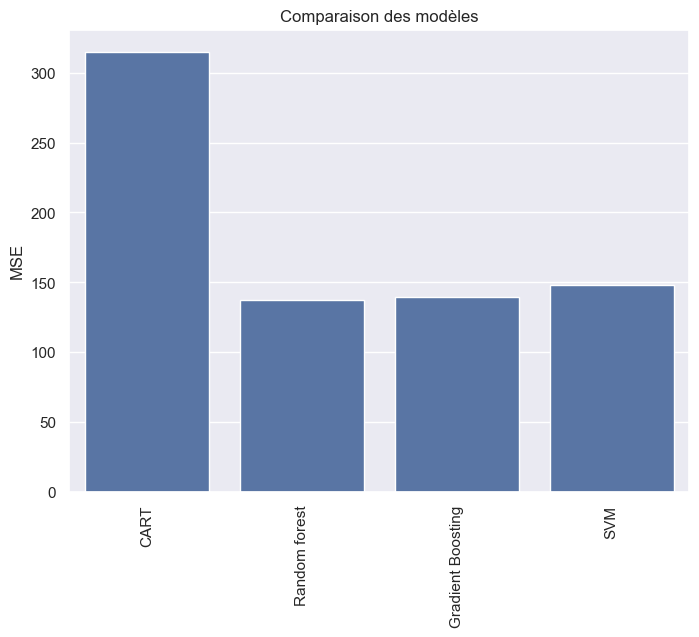

In [42]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=mse_model.keys(), y=mse_model.values())
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('MSE')
ax.set_title('Comparaison des modèles')
plt.show()

In [43]:
mae_model = {}

mae_model['CART']              = mae_cart
mae_model['Random forest']     = mae_rf
mae_model['Gradient Boosting'] = mae_gb
mae_model['SVM']               = mae_svm

mae_model

{'CART': 14.28029197080292,
 'Random forest': 9.057468613138687,
 'Gradient Boosting': 9.04784988340532,
 'SVM': 9.356889495341754}

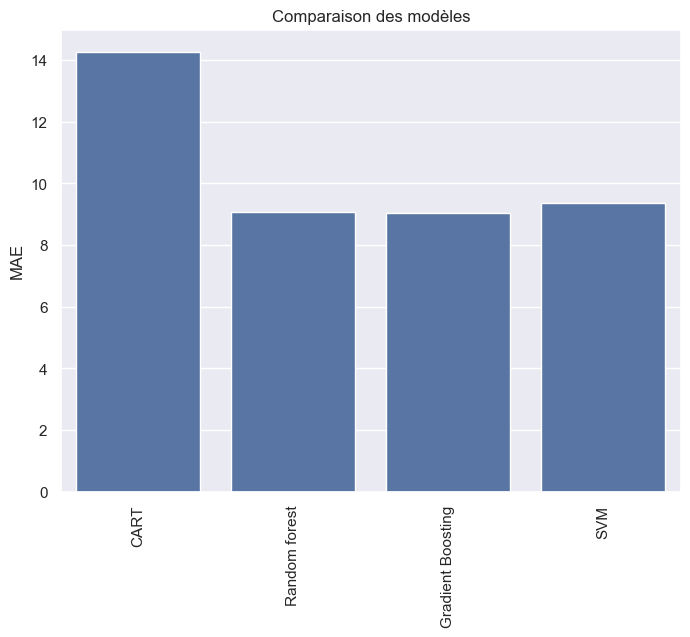

In [44]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=mae_model.keys(), y=mae_model.values())
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('MAE')
ax.set_title('Comparaison des modèles')
plt.show()

In [45]:
mape_model = {}

mape_model['CART']              = mape_cart
mape_model['Random forest']     = mape_rf
mape_model['Gradient Boosting'] = mape_gb
mape_model['SVM']               = mape_svm

mape_model

{'CART': 18.230209789191843,
 'Random forest': 11.826523706361131,
 'Gradient Boosting': 11.951104817547193,
 'SVM': 12.068648333977896}

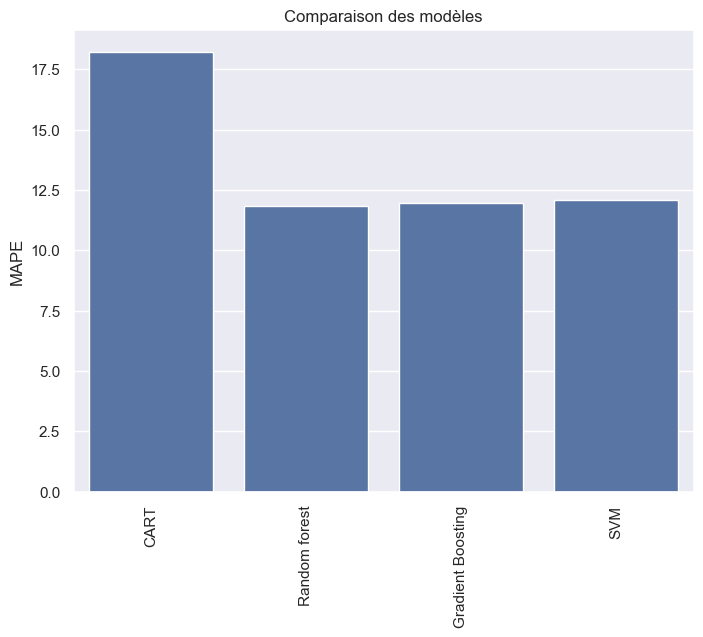

In [46]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=mape_model.keys(), y=mape_model.values())
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('MAPE')
ax.set_title('Comparaison des modèles')
plt.show()

In [47]:
execution_time_model = {}

execution_time_model['CART']              = execution_time_cart
execution_time_model['Random forest']     = execution_time_rf
execution_time_model['Gradient Boosting'] = execution_time_gb
execution_time_model['SVM']               = execution_time_svm

execution_time_model

{'CART': 0.025586843490600586,
 'Random forest': 15.544870853424072,
 'Gradient Boosting': 1.2112650871276855,
 'SVM': 63.61798024177551}

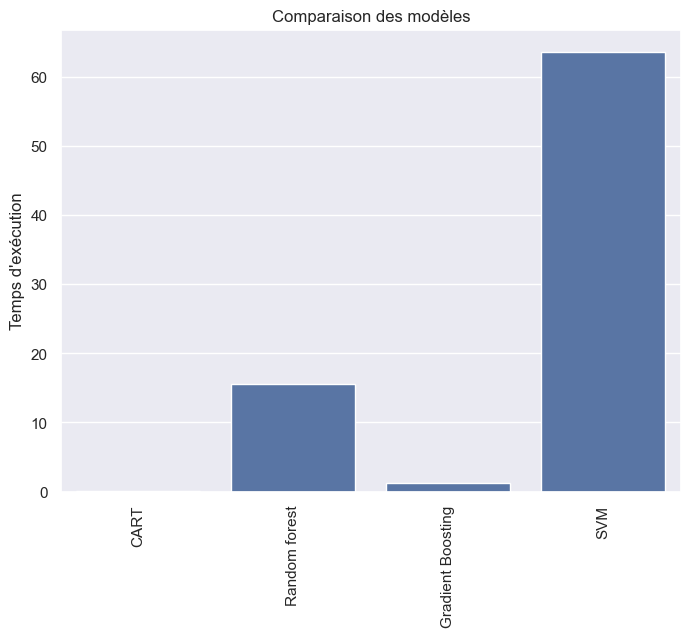

In [48]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=execution_time_model.keys(), y=execution_time_model.values())
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Temps d'exécution")
ax.set_title('Comparaison des modèles')
plt.show()